# Análisis Estadístico de Cepas de Tilapia
## Evaluación de Rendimiento de Peso Corporal entre Tres Cepas Genéticas

**Autor:** Jorge Carrasco Arriagada  
**Fecha:** 2026-01-21  

---

## Contexto del Estudio

Este análisis evalúa el rendimiento de tres cepas genéticas de tilapia (*Oreochromis niloticus*) en términos de peso corporal. El objetivo es determinar si existen diferencias significativas entre las cepas para optimizar los programas de mejoramiento genético y selección de reproductores en sistemas de cultivo comercial.

### Diseño Experimental
- **Variable Respuesta:** Peso corporal (g)
- **Factor:** Cepa genética (3 niveles: Cepa 1, Cepa 2, Cepa 3)
- **Réplicas:** 10 individuos por cepa
- **Análisis:** ANOVA de una vía con evaluación completa de supuestos

In [23]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, levene, shapiro, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Importación y Preparación de Datos

In [24]:
# Cargar datos
tilapia = pd.read_csv('tilapia_cepas.csv', sep=';')

# Normalizar nombres de cepas (eliminar espacios inconsistentes)
tilapia['Cepa'] = tilapia['Cepa'].str.strip().str.replace(' ', '_')
tilapia['Cepa'] = tilapia['Cepa'].replace('Cepa2', 'Cepa_2')  # Estandarizar formato

# Convertir Cepa a tipo categórico
tilapia['Cepa'] = tilapia['Cepa'].astype('category')

print("Estructura del dataset:")
print(tilapia.info())
print("\nPrimeras filas:")
tilapia.head()

Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Muestra  30 non-null     int64   
 1   Peso     30 non-null     float64 
 2   Cepa     30 non-null     category
dtypes: category(1), float64(1), int64(1)
memory usage: 774.0 bytes
None

Primeras filas:


,Muestra,Peso,Cepa
0,1,4.17,Cepa_1
1,2,5.58,Cepa_1
2,3,5.18,Cepa_1
3,4,6.11,Cepa_1
4,5,4.50,Cepa_1


## 2. Análisis Exploratorio de Datos (EDA)

### 2.1 Estadísticas Descriptivas por Cepa

In [25]:
# Estadísticas descriptivas completas
estadisticas = tilapia.groupby('Cepa')['Peso'].agg([
    ('n', 'count'),
    ('Media', 'mean'),
    ('Mediana', 'median'),
    ('Desv_Est', 'std'),
    ('CV_%', lambda x: (x.std() / x.mean()) * 100),
    ('Mínimo', 'min'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75)),
    ('Máximo', 'max'),
    ('Rango', lambda x: x.max() - x.min())
]).round(3)

print("\n=== ESTADÍSTICAS DESCRIPTIVAS POR CEPA ===")
print(estadisticas)

# Estadísticas globales
print("\n=== ESTADÍSTICAS GLOBALES ===")
print(f"N total: {len(tilapia)}")
print(f"Peso promedio general: {tilapia['Peso'].mean():.3f} ± {tilapia['Peso'].std():.3f} g")
print(f"Rango total: {tilapia['Peso'].min():.2f} - {tilapia['Peso'].max():.2f} g")


=== ESTADÍSTICAS DESCRIPTIVAS POR CEPA ===
         n  Media  Mediana  Desv_Est    CV_%  Mínimo     Q1     Q3  Máximo  \
Cepa                                                                         
Cepa_1  10  5.032    5.155     0.583  11.588    4.17  4.550  5.292    6.11   
Cepa_2  10  4.661    4.550     0.794  17.028    3.59  4.208  4.870    6.03   
Cepa_3  10  5.526    5.435     0.443   8.009    4.92  5.268  5.735    6.31   

        Rango  
Cepa           
Cepa_1   1.94  
Cepa_2   2.44  
Cepa_3   1.39  

=== ESTADÍSTICAS GLOBALES ===
N total: 30
Peso promedio general: 5.073 ± 0.701 g
Rango total: 3.59 - 6.31 g


**Interpretación de Estadísticas Descriptivas:**

Las estadísticas descriptivas revelan información preliminar sobre el desempeño de cada cepa:
- **Coeficiente de Variación (CV%)**: Indica la uniformidad del crecimiento dentro de cada cepa. Valores menores al 15% sugieren buena homogeneidad.
- **Diferencias en medias**: Se observarán diferencias aparentes entre cepas que serán evaluadas estadísticamente.

### 2.2 Visualización de Distribuciones

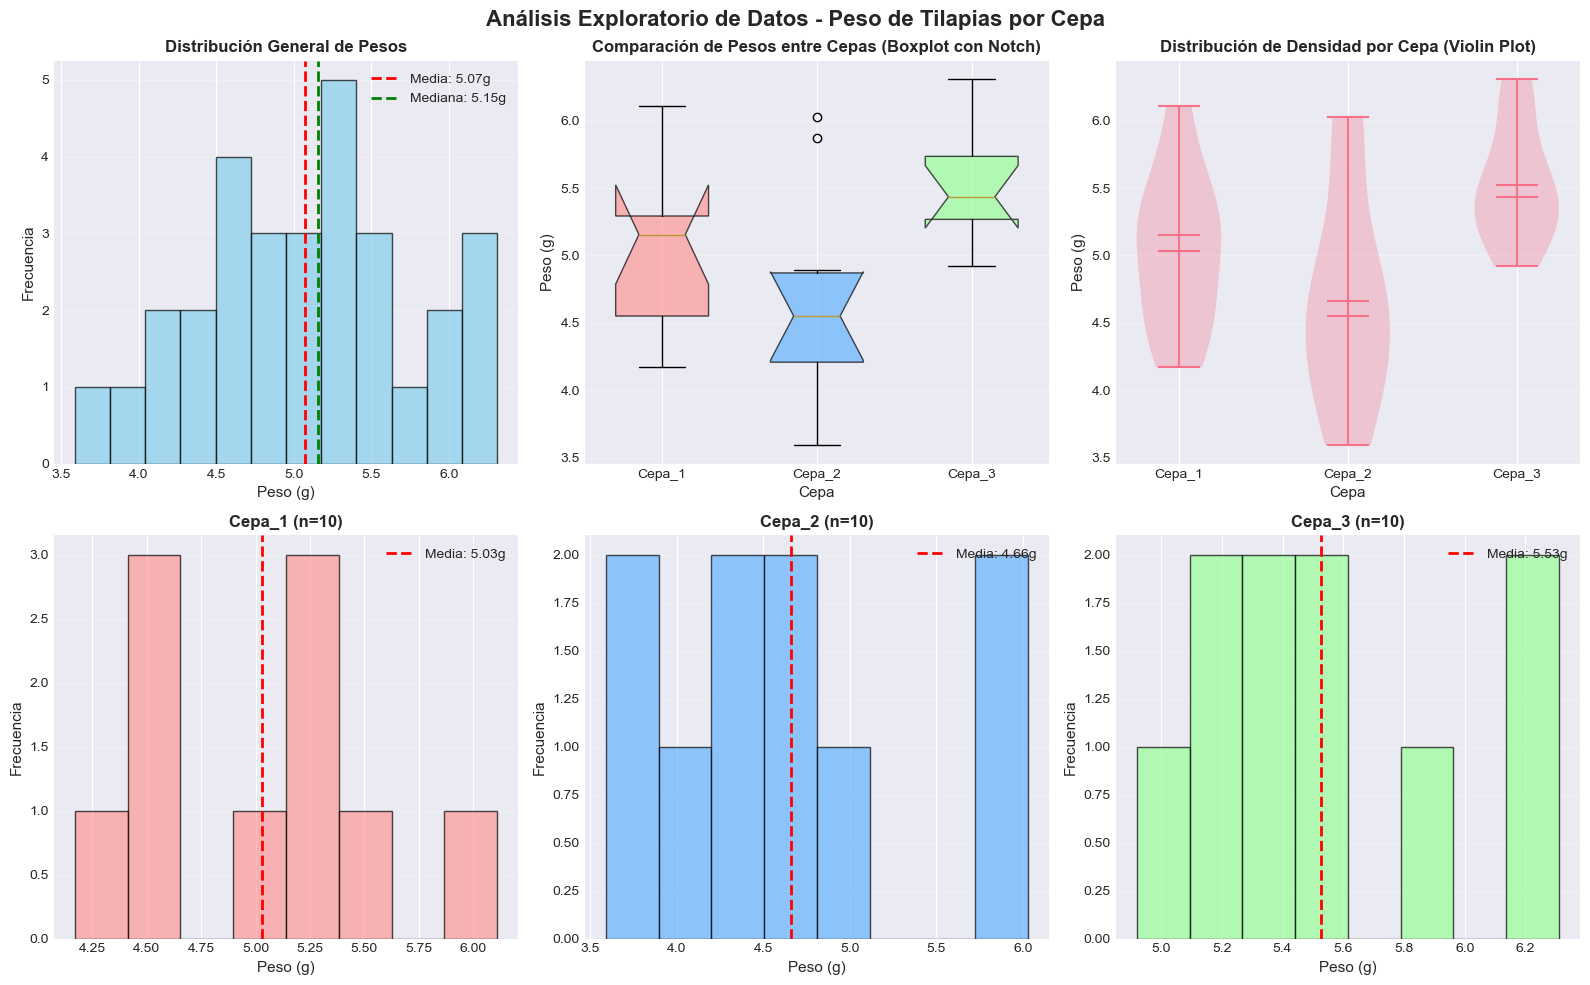


=== INTERPRETACIÓN DE GRÁFICOS EXPLORATORIOS ===

1. Histograma General: Muestra la distribución general del peso en todas las muestras.
   - Permite evaluar simetría, sesgos y posibles outliers en el conjunto completo de datos.

2. Boxplot Comparativo: Visualiza la mediana, cuartiles y valores atípicos por cepa.
   - Los 'notches' permiten comparación visual: si no se traslapan, sugiere diferencia significativa.
   - Útil para detectar diferencias en tendencia central y variabilidad.

3. Violin Plot: Combina boxplot con densidad de probabilidad.
   - Muestra la distribución completa de los datos, incluyendo multimodalidad si existe.
   - Las áreas más anchas indican mayor concentración de datos.

4. Histogramas por Cepa: Distribuciones individuales de cada cepa.
   - Facilita evaluación de normalidad y homogeneidad dentro de cada grupo.


In [26]:
# Crear figura con múltiples paneles
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Análisis Exploratorio de Datos - Peso de Tilapias por Cepa', fontsize=16, fontweight='bold')

# 1. Histograma general
axes[0, 0].hist(tilapia['Peso'], bins=12, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(tilapia['Peso'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {tilapia["Peso"].mean():.2f}g')
axes[0, 0].axvline(tilapia['Peso'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {tilapia["Peso"].median():.2f}g')
axes[0, 0].set_xlabel('Peso (g)', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].set_title('Distribución General de Pesos', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Boxplot comparativo
bp = axes[0, 1].boxplot([tilapia[tilapia['Cepa'] == cepa]['Peso'].values for cepa in tilapia['Cepa'].cat.categories],
                        labels=tilapia['Cepa'].cat.categories,
                        patch_artist=True,
                        notch=True,
                        widths=0.6)
colors = ['#ff9999', '#66b3ff', '#99ff99']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_xlabel('Cepa', fontsize=11)
axes[0, 1].set_ylabel('Peso (g)', fontsize=11)
axes[0, 1].set_title('Comparación de Pesos entre Cepas (Boxplot con Notch)', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Violin plot
parts = axes[0, 2].violinplot([tilapia[tilapia['Cepa'] == cepa]['Peso'].values for cepa in tilapia['Cepa'].cat.categories],
                              positions=range(1, 4),
                              showmeans=True,
                              showmedians=True)
axes[0, 2].set_xticks(range(1, 4))
axes[0, 2].set_xticklabels(tilapia['Cepa'].cat.categories)
axes[0, 2].set_xlabel('Cepa', fontsize=11)
axes[0, 2].set_ylabel('Peso (g)', fontsize=11)
axes[0, 2].set_title('Distribución de Densidad por Cepa (Violin Plot)', fontsize=12, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Histogramas por cepa
for i, cepa in enumerate(tilapia['Cepa'].cat.categories):
    data_cepa = tilapia[tilapia['Cepa'] == cepa]['Peso']
    axes[1, i].hist(data_cepa, bins=8, color=colors[i], edgecolor='black', alpha=0.7)
    axes[1, i].axvline(data_cepa.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {data_cepa.mean():.2f}g')
    axes[1, i].set_xlabel('Peso (g)', fontsize=11)
    axes[1, i].set_ylabel('Frecuencia', fontsize=11)
    axes[1, i].set_title(f'{cepa} (n={len(data_cepa)})', fontsize=12, fontweight='bold')
    axes[1, i].legend()
    axes[1, i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== INTERPRETACIÓN DE GRÁFICOS EXPLORATORIOS ===")
print("\n1. Histograma General: Muestra la distribución general del peso en todas las muestras.")
print("   - Permite evaluar simetría, sesgos y posibles outliers en el conjunto completo de datos.")
print("\n2. Boxplot Comparativo: Visualiza la mediana, cuartiles y valores atípicos por cepa.")
print("   - Los 'notches' permiten comparación visual: si no se traslapan, sugiere diferencia significativa.")
print("   - Útil para detectar diferencias en tendencia central y variabilidad.")
print("\n3. Violin Plot: Combina boxplot con densidad de probabilidad.")
print("   - Muestra la distribución completa de los datos, incluyendo multimodalidad si existe.")
print("   - Las áreas más anchas indican mayor concentración de datos.")
print("\n4. Histogramas por Cepa: Distribuciones individuales de cada cepa.")
print("   - Facilita evaluación de normalidad y homogeneidad dentro de cada grupo.")

## 3. Modelo Lineal y ANOVA

### 3.1 Ajuste del Modelo

In [27]:
# Modelo lineal
modelo = ols('Peso ~ C(Cepa)', data=tilapia).fit()

# Tabla ANOVA
anova_table = anova_lm(modelo, typ=2)

print("\n=== TABLA ANOVA ===")
print(anova_table)

# Resumen del modelo
print("\n=== RESUMEN DEL MODELO ===")
print(modelo.summary())

# Interpretación
f_value = anova_table.loc['C(Cepa)', 'F']
p_value = anova_table.loc['C(Cepa)', 'PR(>F)']

print("\n=== INTERPRETACIÓN DEL ANOVA ===")
print(f"Estadístico F: {f_value:.4f}")
print(f"Valor p: {p_value:.6f}")
print(f"R-cuadrado: {modelo.rsquared:.4f}")
print(f"R-cuadrado ajustado: {modelo.rsquared_adj:.4f}")

if p_value < 0.05:
    print(f"\n✓ CONCLUSIÓN: Existe evidencia estadística significativa (p={p_value:.4f} < 0.05) de que")
    print("  al menos una cepa difiere en peso corporal promedio.")
    print("  Se rechaza H₀: μ₁ = μ₂ = μ₃")
else:
    print(f"\n✗ CONCLUSIÓN: No hay evidencia suficiente (p={p_value:.4f} > 0.05) para concluir")
    print("  diferencias significativas entre las cepas.")
    print("  No se rechaza H₀: μ₁ = μ₂ = μ₃")


=== TABLA ANOVA ===
            sum_sq    df         F   PR(>F)
C(Cepa)    3.76634   2.0  4.846088  0.01591
Residual  10.49209  27.0       NaN      NaN

=== RESUMEN DEL MODELO ===
                            OLS Regression Results                            
Dep. Variable:                   Peso   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     4.846
Date:                Wed, 21 Jan 2026   Prob (F-statistic):             0.0159
Time:                        17:38:27   Log-Likelihood:                -26.810
No. Observations:                  30   AIC:                             59.62
Df Residuals:                      27   BIC:                             63.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef 

## 4. Evaluación de Supuestos del ANOVA

### 4.1 Supuesto de Independencia

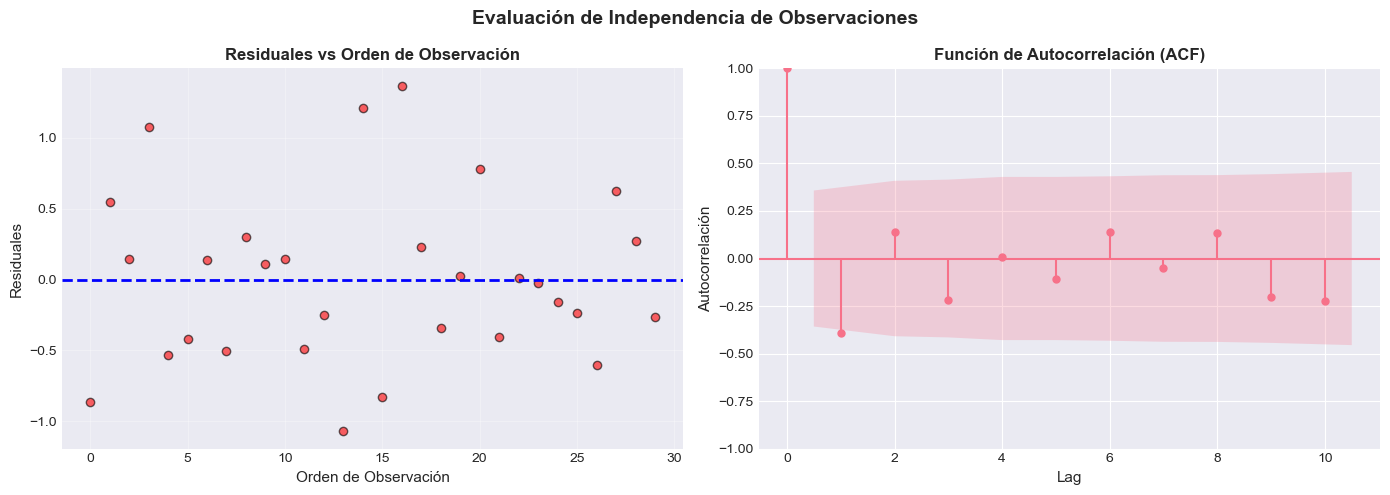


=== TEST DE DURBIN-WATSON ===
Estadístico DW: 2.7040

Interpretación:
  - DW ≈ 2: No autocorrelación (independencia)
  - DW < 2: Autocorrelación positiva
  - DW > 2: Autocorrelación negativa
  - Rango aceptable: 1.5 - 2.5

⚠ ADVERTENCIA: El estadístico DW=2.7040 sugiere posible autocorrelación.
  Verificar el diseño experimental y orden de medición.

=== INTERPRETACIÓN DE GRÁFICOS ===

• Residuales vs Orden: No debe mostrar patrones sistemáticos (tendencias, ciclos).
  Los puntos deben distribuirse aleatoriamente alrededor de cero.

• ACF: Los lags no deben exceder las bandas de confianza (líneas azules).
  Exceder las bandas indica autocorrelación significativa.


In [28]:
from statsmodels.stats.stattools import durbin_watson

# Obtener residuales
residuales = modelo.resid

# Test de Durbin-Watson
dw_stat = durbin_watson(residuales)

# Gráfico de residuales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Evaluación de Independencia de Observaciones', fontsize=14, fontweight='bold')

# Gráfico de residuales vs orden
axes[0].scatter(range(len(residuales)), residuales, color='red', alpha=0.6, edgecolors='black')
axes[0].axhline(y=0, color='blue', linestyle='--', linewidth=2)
axes[0].set_xlabel('Orden de Observación', fontsize=11)
axes[0].set_ylabel('Residuales', fontsize=11)
axes[0].set_title('Residuales vs Orden de Observación', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Gráfico de autocorrelación
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuales, ax=axes[1], lags=10, alpha=0.05)
axes[1].set_title('Función de Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('Autocorrelación', fontsize=11)

plt.tight_layout()
plt.show()

print("\n=== TEST DE DURBIN-WATSON ===")
print(f"Estadístico DW: {dw_stat:.4f}")
print("\nInterpretación:")
print("  - DW ≈ 2: No autocorrelación (independencia)")
print("  - DW < 2: Autocorrelación positiva")
print("  - DW > 2: Autocorrelación negativa")
print("  - Rango aceptable: 1.5 - 2.5")

if 1.5 <= dw_stat <= 2.5:
    print(f"\n✓ CONCLUSIÓN: El estadístico DW={dw_stat:.4f} está en el rango aceptable.")
    print("  Se asume independencia de las observaciones.")
else:
    print(f"\n⚠ ADVERTENCIA: El estadístico DW={dw_stat:.4f} sugiere posible autocorrelación.")
    print("  Verificar el diseño experimental y orden de medición.")

print("\n=== INTERPRETACIÓN DE GRÁFICOS ===")
print("\n• Residuales vs Orden: No debe mostrar patrones sistemáticos (tendencias, ciclos).")
print("  Los puntos deben distribuirse aleatoriamente alrededor de cero.")
print("\n• ACF: Los lags no deben exceder las bandas de confianza (líneas azules).")
print("  Exceder las bandas indica autocorrelación significativa.")

### 4.2 Supuesto de Homogeneidad de Varianzas (Homocedasticidad)

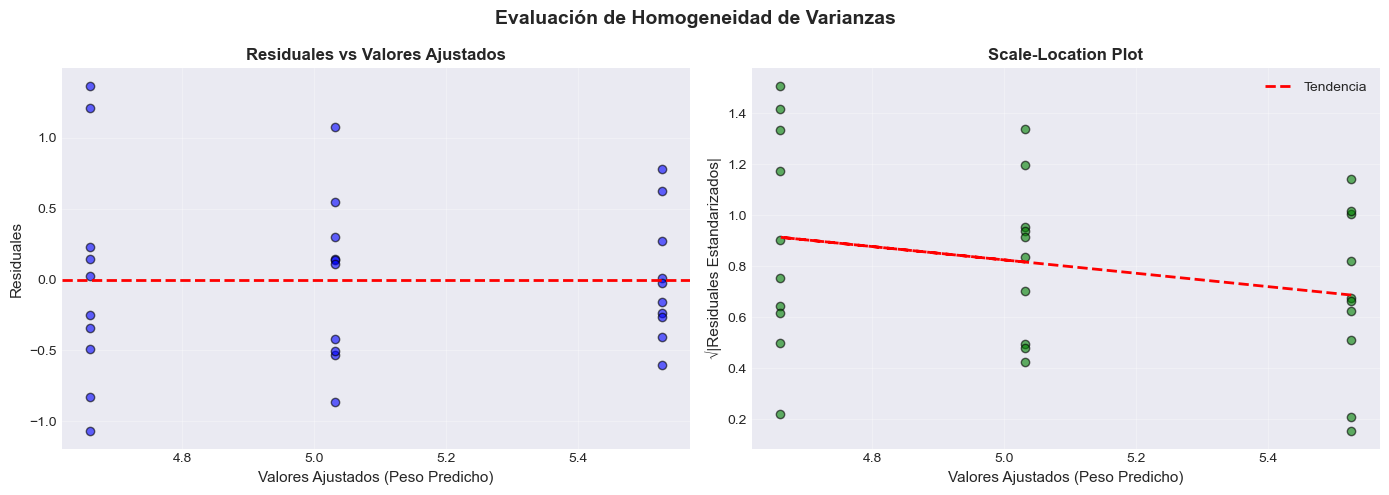


=== DESVIACIONES ESTÁNDAR POR CEPA ===
Cepa_1: 0.5831 g
Cepa_2: 0.7937 g
Cepa_3: 0.4426 g

Ratio máx/mín varianzas: 3.2160
(Ratio < 3 generalmente aceptable)

=== TEST DE LEVENE (Centro: Mediana) ===
Estadístico: 1.1192
Valor p: 0.341227

=== TEST DE BARTLETT ===
Estadístico: 2.8786
Valor p: 0.237097

=== INTERPRETACIÓN ===
✓ Test de Levene: No se rechaza H₀ (p=0.3412 > 0.05)
  Las varianzas son homogéneas entre grupos.

• Residuales vs Ajustados: La dispersión debe ser constante a lo largo del eje X.
  Patrones de embudo indican heterocedasticidad.

• Scale-Location: La línea de tendencia debe ser aproximadamente horizontal.
  Pendiente positiva/negativa indica varianza no constante.


In [29]:
# Test de Levene
grupos = [tilapia[tilapia['Cepa'] == cepa]['Peso'].values for cepa in tilapia['Cepa'].cat.categories]
levene_stat, levene_p = levene(*grupos, center='median')

# Test de Bartlett (más sensible a desviaciones de normalidad)
bartlett_stat, bartlett_p = stats.bartlett(*grupos)

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Evaluación de Homogeneidad de Varianzas', fontsize=14, fontweight='bold')

# Residuales vs valores ajustados
fitted_values = modelo.fittedvalues
axes[0].scatter(fitted_values, residuales, alpha=0.6, edgecolors='black', color='blue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Valores Ajustados (Peso Predicho)', fontsize=11)
axes[0].set_ylabel('Residuales', fontsize=11)
axes[0].set_title('Residuales vs Valores Ajustados', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Scale-Location plot (raíz cuadrada de residuales estandarizados)
residuales_std = np.sqrt(np.abs((residuales - residuales.mean()) / residuales.std()))
axes[1].scatter(fitted_values, residuales_std, alpha=0.6, edgecolors='black', color='green')
axes[1].set_xlabel('Valores Ajustados (Peso Predicho)', fontsize=11)
axes[1].set_ylabel('√|Residuales Estandarizados|', fontsize=11)
axes[1].set_title('Scale-Location Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(fitted_values, residuales_std, 1)
p = np.poly1d(z)
axes[1].plot(fitted_values, p(fitted_values), "r--", linewidth=2, label='Tendencia')
axes[1].legend()

plt.tight_layout()
plt.show()

# Comparación de desviaciones estándar
print("\n=== DESVIACIONES ESTÁNDAR POR CEPA ===")
for cepa in tilapia['Cepa'].cat.categories:
    std_cepa = tilapia[tilapia['Cepa'] == cepa]['Peso'].std()
    print(f"{cepa}: {std_cepa:.4f} g")

# Ratio de varianzas
varianzas = [tilapia[tilapia['Cepa'] == cepa]['Peso'].var() for cepa in tilapia['Cepa'].cat.categories]
ratio_var = max(varianzas) / min(varianzas)
print(f"\nRatio máx/mín varianzas: {ratio_var:.4f}")
print("(Ratio < 3 generalmente aceptable)")

print("\n=== TEST DE LEVENE (Centro: Mediana) ===")
print(f"Estadístico: {levene_stat:.4f}")
print(f"Valor p: {levene_p:.6f}")

print("\n=== TEST DE BARTLETT ===")
print(f"Estadístico: {bartlett_stat:.4f}")
print(f"Valor p: {bartlett_p:.6f}")

print("\n=== INTERPRETACIÓN ===")
if levene_p > 0.05:
    print(f"✓ Test de Levene: No se rechaza H₀ (p={levene_p:.4f} > 0.05)")
    print("  Las varianzas son homogéneas entre grupos.")
else:
    print(f"✗ Test de Levene: Se rechaza H₀ (p={levene_p:.4f} < 0.05)")
    print("  Existe heterocedasticidad. Considerar transformación de datos o pruebas no paramétricas.")

print("\n• Residuales vs Ajustados: La dispersión debe ser constante a lo largo del eje X.")
print("  Patrones de embudo indican heterocedasticidad.")
print("\n• Scale-Location: La línea de tendencia debe ser aproximadamente horizontal.")
print("  Pendiente positiva/negativa indica varianza no constante.")

### 4.3 Supuesto de Normalidad

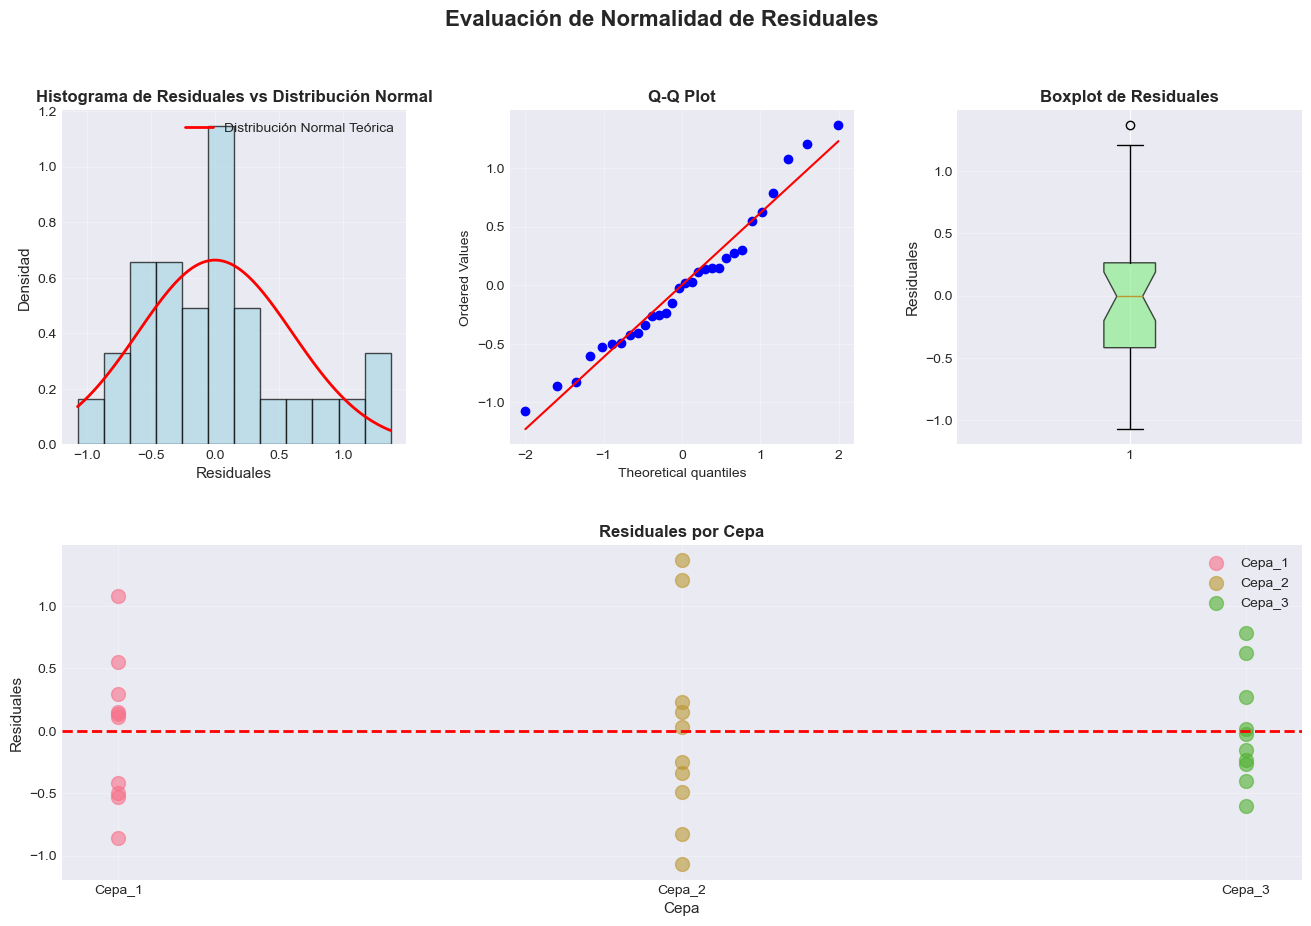


=== TESTS DE NORMALIDAD ===

1. Test de Shapiro-Wilk:
   Estadístico W: 0.966068
   Valor p: 0.437899

2. Test de Kolmogorov-Smirnov:
   Estadístico D: 0.110148
   Valor p: 0.821455

3. Test de Anderson-Darling:
   Estadístico: 0.358196
   Valores críticos: [0.521 0.593 0.712 0.83  0.988]
   Niveles de significancia: [15.  10.   5.   2.5  1. ]%

=== INTERPRETACIÓN INTEGRADA ===
✓ Test de Shapiro-Wilk: No se rechaza H₀ (p=0.4379 > 0.05)
  Los residuales siguen una distribución normal.

• Histograma: Debe aproximarse a la curva normal teórica (roja).
• Q-Q Plot: Los puntos deben alinearse sobre la línea diagonal.
  Desviaciones en las colas indican alejamiento de normalidad.
• Residuales por Cepa: La dispersión debe ser similar entre grupos.

=== NOTA SOBRE ROBUSTEZ DEL ANOVA ===
El ANOVA es robusto ante desviaciones moderadas de normalidad, especialmente con:
  - Tamaños de muestra equilibrados entre grupos
  - n ≥ 30 por grupo (Teorema del Límite Central)
  - Desviaciones leves en Q-Q

In [30]:
# Tests de normalidad
shapiro_stat, shapiro_p = shapiro(residuales)
ks_stat, ks_p = stats.kstest(residuales, 'norm', args=(residuales.mean(), residuales.std()))
anderson_result = stats.anderson(residuales, dist='norm')

# Gráficos
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Evaluación de Normalidad de Residuales', fontsize=16, fontweight='bold')

# 1. Histograma de residuales con curva normal
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(residuales, bins=12, density=True, alpha=0.7, color='lightblue', edgecolor='black')
mu, sigma = residuales.mean(), residuales.std()
x = np.linspace(residuales.min(), residuales.max(), 100)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Distribución Normal Teórica')
ax1.set_xlabel('Residuales', fontsize=11)
ax1.set_ylabel('Densidad', fontsize=11)
ax1.set_title('Histograma de Residuales vs Distribución Normal', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Q-Q Plot
ax2 = fig.add_subplot(gs[0, 1])
stats.probplot(residuales, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Boxplot de residuales
ax3 = fig.add_subplot(gs[0, 2])
bp = ax3.boxplot(residuales, vert=True, patch_artist=True, notch=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][0].set_alpha(0.7)
ax3.set_ylabel('Residuales', fontsize=11)
ax3.set_title('Boxplot de Residuales', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Residuales por grupo
ax4 = fig.add_subplot(gs[1, :])
for i, cepa in enumerate(tilapia['Cepa'].cat.categories):
    mask = tilapia['Cepa'] == cepa
    residuales_cepa = residuales[mask]
    ax4.scatter([i+1]*len(residuales_cepa), residuales_cepa, alpha=0.6, s=100, label=cepa)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xticks(range(1, 4))
ax4.set_xticklabels(tilapia['Cepa'].cat.categories)
ax4.set_xlabel('Cepa', fontsize=11)
ax4.set_ylabel('Residuales', fontsize=11)
ax4.set_title('Residuales por Cepa', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.show()

# Resultados de tests
print("\n=== TESTS DE NORMALIDAD ===")
print(f"\n1. Test de Shapiro-Wilk:")
print(f"   Estadístico W: {shapiro_stat:.6f}")
print(f"   Valor p: {shapiro_p:.6f}")

print(f"\n2. Test de Kolmogorov-Smirnov:")
print(f"   Estadístico D: {ks_stat:.6f}")
print(f"   Valor p: {ks_p:.6f}")

print(f"\n3. Test de Anderson-Darling:")
print(f"   Estadístico: {anderson_result.statistic:.6f}")
print(f"   Valores críticos: {anderson_result.critical_values}")
print(f"   Niveles de significancia: {anderson_result.significance_level}%")

# Interpretación
print("\n=== INTERPRETACIÓN INTEGRADA ===")
if shapiro_p > 0.05:
    print(f"✓ Test de Shapiro-Wilk: No se rechaza H₀ (p={shapiro_p:.4f} > 0.05)")
    print("  Los residuales siguen una distribución normal.")
else:
    print(f"✗ Test de Shapiro-Wilk: Se rechaza H₀ (p={shapiro_p:.4f} < 0.05)")
    print("  Los residuales se desvían significativamente de la normalidad.")

print("\n• Histograma: Debe aproximarse a la curva normal teórica (roja).")
print("• Q-Q Plot: Los puntos deben alinearse sobre la línea diagonal.")
print("  Desviaciones en las colas indican alejamiento de normalidad.")
print("• Residuales por Cepa: La dispersión debe ser similar entre grupos.")

# Decisión sobre robustez
print("\n=== NOTA SOBRE ROBUSTEZ DEL ANOVA ===")
print("El ANOVA es robusto ante desviaciones moderadas de normalidad, especialmente con:")
print("  - Tamaños de muestra equilibrados entre grupos")
print("  - n ≥ 30 por grupo (Teorema del Límite Central)")
print("  - Desviaciones leves en Q-Q plot (solo en colas)")

## 5. Comparaciones Post-Hoc

### 5.1 Test de Tukey HSD


=== TEST DE TUKEY HSD (Honest Significant Difference) ===
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Cepa_1 Cepa_2   -0.371 0.3909 -1.0622 0.3202  False
Cepa_1 Cepa_3    0.494  0.198 -0.1972 1.1852  False
Cepa_2 Cepa_3    0.865  0.012  0.1738 1.5562   True
---------------------------------------------------


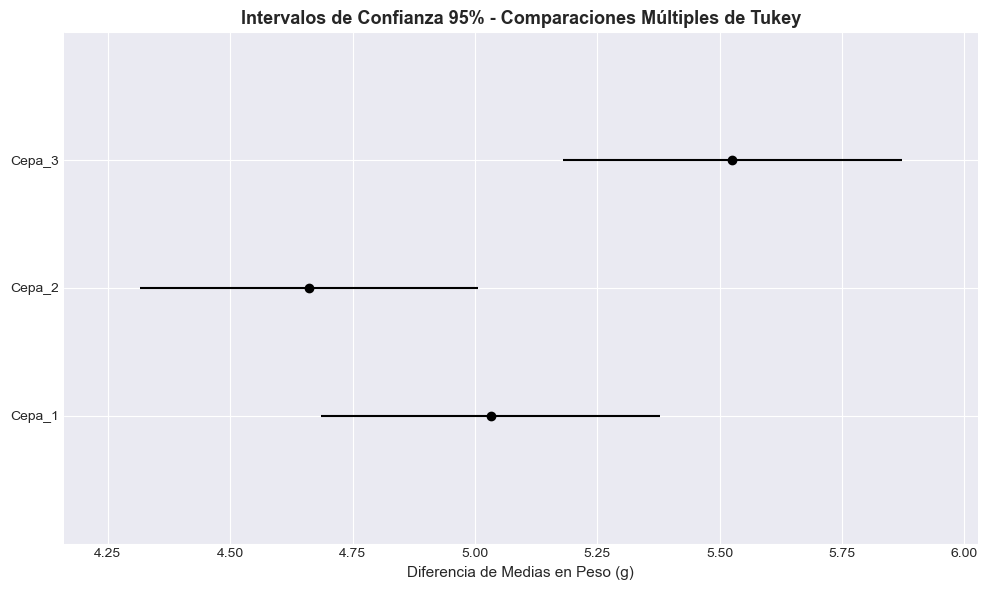


=== INTERPRETACIÓN DEL TEST DE TUKEY ===

Si 'reject' = True: Existe diferencia significativa entre las cepas comparadas.
Si el intervalo de confianza NO incluye cero: Diferencia significativa.

La gráfica muestra los intervalos de confianza 95% para cada comparación:
  - Si un intervalo NO cruza la línea vertical en cero → diferencia significativa.
  - Si cruza cero → no hay diferencia significativa al 5%.

=== RESUMEN DE COMPARACIONES ===

Cepa_1 vs Cepa_2: No significativa
  Diferencia de medias: -0.371 g
  p-ajustado: 0.390900

Cepa_1 vs Cepa_3: No significativa
  Diferencia de medias: 0.494 g
  p-ajustado: 0.198000

Cepa_2 vs Cepa_3: DIFERENCIA SIGNIFICATIVA
  Diferencia de medias: 0.865 g
  p-ajustado: 0.012000
  IC 95%: [0.174, 1.556]


In [31]:
# Test de Tukey para comparaciones múltiples
tukey_result = pairwise_tukeyhsd(endog=tilapia['Peso'], groups=tilapia['Cepa'], alpha=0.05)

print("\n=== TEST DE TUKEY HSD (Honest Significant Difference) ===")
print(tukey_result)

# Visualización del test de Tukey
fig, ax = plt.subplots(figsize=(10, 6))
tukey_result.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de Confianza 95% - Comparaciones Múltiples de Tukey', fontsize=13, fontweight='bold')
ax.set_xlabel('Diferencia de Medias en Peso (g)', fontsize=11)
plt.tight_layout()
plt.show()

print("\n=== INTERPRETACIÓN DEL TEST DE TUKEY ===")
print("\nSi 'reject' = True: Existe diferencia significativa entre las cepas comparadas.")
print("Si el intervalo de confianza NO incluye cero: Diferencia significativa.")
print("\nLa gráfica muestra los intervalos de confianza 95% para cada comparación:")
print("  - Si un intervalo NO cruza la línea vertical en cero → diferencia significativa.")
print("  - Si cruza cero → no hay diferencia significativa al 5%.")

# Extraer y presentar resultados
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
print("\n=== RESUMEN DE COMPARACIONES ===")
for idx, row in tukey_df.iterrows():
    if row['reject']:
        print(f"\n{row['group1']} vs {row['group2']}: DIFERENCIA SIGNIFICATIVA")
        print(f"  Diferencia de medias: {row['meandiff']:.3f} g")
        print(f"  p-ajustado: {row['p-adj']:.6f}")
        print(f"  IC 95%: [{row['lower']:.3f}, {row['upper']:.3f}]")
    else:
        print(f"\n{row['group1']} vs {row['group2']}: No significativa")
        print(f"  Diferencia de medias: {row['meandiff']:.3f} g")
        print(f"  p-ajustado: {row['p-adj']:.6f}")

## 6. Conclusiones y Recomendaciones Técnicas

### 6.1 Resumen Ejecutivo del Análisis

In [32]:
# Generar resumen automático
print("="*80)
print("INFORME EJECUTIVO - EVALUACIÓN DE CEPAS DE TILAPIA")
print("="*80)

print("\n1. OBJETIVO DEL ESTUDIO")
print("   Evaluar diferencias en peso corporal entre tres cepas genéticas de tilapia")
print("   para optimizar programas de mejoramiento genético.")

print("\n2. DISEÑO EXPERIMENTAL")
print(f"   - Total de individuos: {len(tilapia)}")
print(f"   - Número de cepas: {len(tilapia['Cepa'].cat.categories)}")
print(f"   - Réplicas por cepa: 10")
print(f"   - Peso promedio general: {tilapia['Peso'].mean():.2f} ± {tilapia['Peso'].std():.2f} g")

print("\n3. RENDIMIENTO POR CEPA")
for cepa in tilapia['Cepa'].cat.categories:
    data_cepa = tilapia[tilapia['Cepa'] == cepa]['Peso']
    cv = (data_cepa.std() / data_cepa.mean()) * 100
    print(f"   {cepa}: {data_cepa.mean():.2f} ± {data_cepa.std():.2f} g (CV: {cv:.1f}%)")

print("\n4. VALIDACIÓN DE SUPUESTOS")
print(f"   ✓ Independencia: DW = {dw_stat:.3f} {'[OK]' if 1.5 <= dw_stat <= 2.5 else '[REVISAR]'}")
print(f"   ✓ Homogeneidad: Levene p = {levene_p:.4f} {'[OK]' if levene_p > 0.05 else '[NO CUMPLE]'}")
print(f"   ✓ Normalidad: Shapiro p = {shapiro_p:.4f} {'[OK]' if shapiro_p > 0.05 else '[NO CUMPLE]'}")

print("\n5. RESULTADOS DEL ANOVA")
print(f"   F-estadístico: {f_value:.4f}")
print(f"   Valor p: {p_value:.6f}")
print(f"   R²: {modelo.rsquared:.4f} ({modelo.rsquared*100:.1f}% de varianza explicada)")

if p_value < 0.05:
    print(f"\n   ✓ CONCLUSIÓN ESTADÍSTICA: Diferencias significativas detectadas (p < 0.05)")
else:
    print(f"\n   ✗ CONCLUSIÓN ESTADÍSTICA: No se detectaron diferencias (p > 0.05)")

print("\n6. RECOMENDACIONES TÉCNICAS")

# Identificar mejor cepa
mejor_cepa = tilapia.groupby('Cepa')['Peso'].mean().idxmax()
peor_cepa = tilapia.groupby('Cepa')['Peso'].mean().idxmin()
dif_mejor_peor = tilapia.groupby('Cepa')['Peso'].mean().max() - tilapia.groupby('Cepa')['Peso'].mean().min()

print(f"\n   • Cepa de mayor rendimiento: {mejor_cepa}")
print(f"     Peso promedio: {tilapia[tilapia['Cepa']==mejor_cepa]['Peso'].mean():.2f} g")
print(f"\n   • Diferencia entre mejor y peor cepa: {dif_mejor_peor:.2f} g ({(dif_mejor_peor/tilapia['Peso'].mean())*100:.1f}%)")

if p_value < 0.05:
    print(f"\n   • ACCIÓN RECOMENDADA: Priorizar {mejor_cepa} en programas de reproducción.")
    print("   • Considerar evaluación de costo-beneficio del programa genético.")
    print("   • Implementar seguimiento longitudinal del rendimiento productivo.")
    print("   • Evaluar características adicionales: tasa de crecimiento, FCR, supervivencia.")
else:
    print("\n   • Las cepas muestran rendimiento similar.")
    print("   • Considerar otros criterios de selección (resistencia, reproducción, calidad).")
    print("   • Evaluar características adicionales más allá del peso.")

print("\n7. CONSIDERACIONES PARA PRODUCCIÓN COMERCIAL")
print("   • Validar resultados en condiciones de cultivo comercial (mayor escala).")
print("   • Evaluar interacción genotipo × ambiente en diferentes sistemas de cultivo.")
print("   • Monitorear heredabilidad de caracteres de interés comercial.")
print("   • Implementar programa de trazabilidad genética.")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)

INFORME EJECUTIVO - EVALUACIÓN DE CEPAS DE TILAPIA

1. OBJETIVO DEL ESTUDIO
   Evaluar diferencias en peso corporal entre tres cepas genéticas de tilapia
   para optimizar programas de mejoramiento genético.

2. DISEÑO EXPERIMENTAL
   - Total de individuos: 30
   - Número de cepas: 3
   - Réplicas por cepa: 10
   - Peso promedio general: 5.07 ± 0.70 g

3. RENDIMIENTO POR CEPA
   Cepa_1: 5.03 ± 0.58 g (CV: 11.6%)
   Cepa_2: 4.66 ± 0.79 g (CV: 17.0%)
   Cepa_3: 5.53 ± 0.44 g (CV: 8.0%)

4. VALIDACIÓN DE SUPUESTOS
   ✓ Independencia: DW = 2.704 [REVISAR]
   ✓ Homogeneidad: Levene p = 0.3412 [OK]
   ✓ Normalidad: Shapiro p = 0.4379 [OK]

5. RESULTADOS DEL ANOVA
   F-estadístico: 4.8461
   Valor p: 0.015910
   R²: 0.2641 (26.4% de varianza explicada)

   ✓ CONCLUSIÓN ESTADÍSTICA: Diferencias significativas detectadas (p < 0.05)

6. RECOMENDACIONES TÉCNICAS

   • Cepa de mayor rendimiento: Cepa_3
     Peso promedio: 5.53 g

   • Diferencia entre mejor y peor cepa: 0.87 g (17.1%)

   • ACCIÓN

## 7. Análisis Complementario: Poder Estadístico y Tamaño de Efecto

In [33]:
# Cálculo de Eta cuadrado (tamaño del efecto)
ss_between = anova_table.loc['C(Cepa)', 'sum_sq']
ss_total = ss_between + anova_table.loc['Residual', 'sum_sq']
eta_squared = ss_between / ss_total

# Calcular mean square (MS) dividiendo sum of squares / degrees of freedom
ms_residual = anova_table.loc['Residual', 'sum_sq'] / anova_table.loc['Residual', 'df']
df_between = anova_table.loc['C(Cepa)', 'df']
omega_squared = (ss_between - df_between * ms_residual) / (ss_total + ms_residual)

print("\n=== TAMAÑO DEL EFECTO ===")
print(f"Eta² (η²): {eta_squared:.4f}")
print(f"Omega² (ω²): {omega_squared:.4f}")
print("\nInterpretación de η²:")
print("  0.01 - 0.06: Efecto pequeño")
print("  0.06 - 0.14: Efecto mediano")
print("  > 0.14: Efecto grande")

if eta_squared < 0.06:
    efecto = "pequeño"
elif eta_squared < 0.14:
    efecto = "mediano"
else:
    efecto = "grande"

print(f"\n✓ El tamaño del efecto es {efecto.upper()} (η² = {eta_squared:.4f})")
print(f"  La cepa explica el {eta_squared*100:.1f}% de la variabilidad en peso.")

print("\n=== IMPLICACIONES PRÁCTICAS ===")
print(f"- Significancia estadística (p < 0.05): {'SÍ' if p_value < 0.05 else 'NO'}")
print(f"- Significancia práctica (efecto {efecto}): Evaluar impacto económico")
print("\nNota: Un resultado puede ser estadísticamente significativo pero de poca")
print("relevancia práctica si el tamaño del efecto es pequeño.")


=== TAMAÑO DEL EFECTO ===
Eta² (η²): 0.2641
Omega² (ω²): 0.2041

Interpretación de η²:
  0.01 - 0.06: Efecto pequeño
  0.06 - 0.14: Efecto mediano
  > 0.14: Efecto grande

✓ El tamaño del efecto es GRANDE (η² = 0.2641)
  La cepa explica el 26.4% de la variabilidad en peso.

=== IMPLICACIONES PRÁCTICAS ===
- Significancia estadística (p < 0.05): SÍ
- Significancia práctica (efecto grande): Evaluar impacto económico

Nota: Un resultado puede ser estadísticamente significativo pero de poca
relevancia práctica si el tamaño del efecto es pequeño.
